c:\Users\marya\anaconda3\envs\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


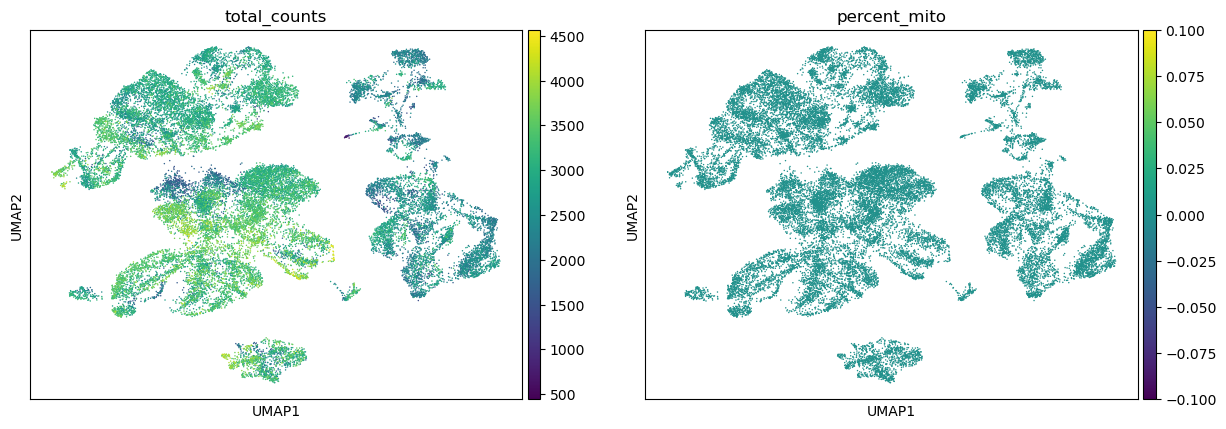

In [26]:
import scanpy as sc
from pathlib import Path

# Load the data
file_path = Path("C:/Users/marya/single-cell-project/Single-Cell-Transcriptomics/410b4cc9-1b18-4c1f-b109-12ed7a796060.h5ad")
adata = sc.read(file_path)

# Compute total counts per cell (sum of counts per cell)
# Sum across genes (axis=1), and flatten to get a 1D array of shape (n_cells,)
adata.obs['total_counts'] = adata.X.sum(axis=1).A1  # A1 flattens the sparse matrix

# Identify mitochondrial genes (assuming they start with 'MT-')
mito_genes = [gene for gene in adata.var_names if gene.startswith('MT-')]

# Sum the expression of mitochondrial genes for each cell
mito_expression = adata[:, mito_genes].X.sum(axis=1).A1  # Sum mitochondrial genes and flatten

# Calculate the percentage of mitochondrial expression
adata.obs['percent_mito'] = (mito_expression / adata.obs['total_counts']) * 100

# Perform quality control by filtering cells and genes
sc.pp.filter_cells(adata, min_counts=200)
sc.pp.filter_genes(adata, min_cells=3)

# Identify highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=min(2000, adata.shape[1]))

# Perform PCA (Principal Component Analysis)
sc.tl.pca(adata, n_comps=50)

# Compute nearest neighbors based on PCA
sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_pca')

# Compute UMAP (Uniform Manifold Approximation and Projection)
sc.tl.umap(adata)

# Plot UMAP colored by total counts and percentage of mitochondrial genes
sc.pl.umap(adata, color=["total_counts", "percent_mito"])


0.8.2
Index(['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'seurat_clusters',
       'donor_id', 'Stage', 'Selection', 'compartment', 'age', 'CnT', 'DTLH',
       'UBCD', 'SSBpr', 'End', 'MSC', 'RVCSB', 'SSBpod', 'SSBm.d', 'ICa',
       'ErPrT', 'ICb', 'NPC', 'Pod', 'annotCell', 'author_cell_type',
       'cell_type_ontology_term_id', 'disease_ontology_term_id',
       'self_reported_ethnicity_ontology_term_id',
       'development_stage_ontology_term_id', 'tissue_ontology_term_id',
       'sex_ontology_term_id', 'organism_ontology_term_id', 'is_primary_data',
       'assay_ontology_term_id', 'suspension_type', 'tissue_type', 'cell_type',
       'assay', 'disease', 'organism', 'sex', 'tissue',
       'self_reported_ethnicity', 'development_stage', 'observation_joinid',
       'total_counts', 'percent_mito', 'n_counts', 'louvain'],
      dtype='object')


c:\Users\marya\anaconda3\envs\myenv\lib\site-packages\scanpy\tools\_rank_genes_groups.py:435: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
c:\Users\marya\anaconda3\envs\myenv\lib\site-packages\scanpy\tools\_rank_genes_groups.py:437: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
c:\Users\marya\anaconda3\envs\myenv\lib\site-packages\scanpy\tools\_rank_genes_groups.py:440: PerformanceWarning: DataFrame is high

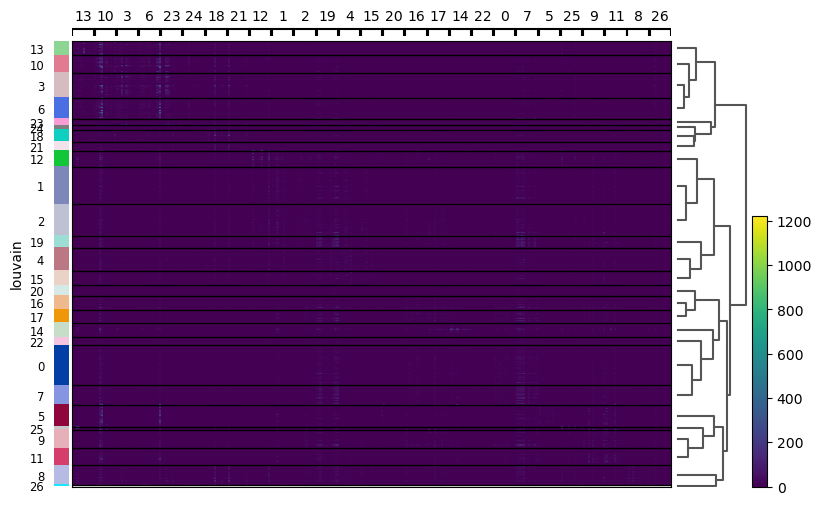

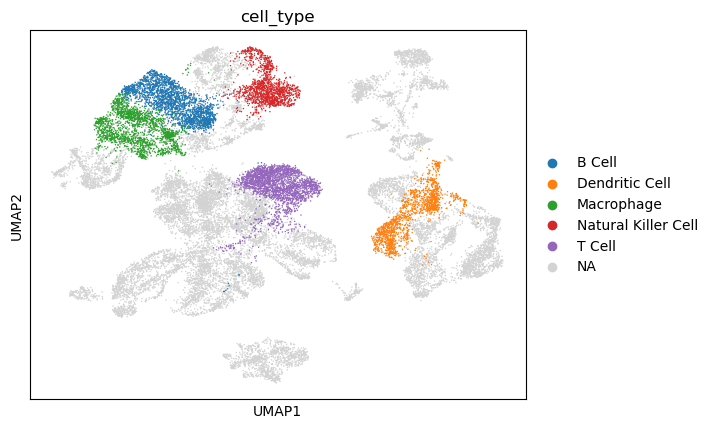

In [ ]:
import scanpy as sc
import louvain
print(louvain.__version__)

# Step 1: Compute nearest neighbors based on PCA (already done in previous workshops)
sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_pca')

# Step 2: Perform ouvLain clustering
sc.tl.louvain(adata, resolution=1.0)

# Ensure the Louvain clustering result is present in adata.obs
print(adata.obs.keys())  # Check if 'louvain' column exists now

# Step 3: Rank genes to identify marker genes for each cluster
sc.tl.rank_genes_groups(adata, groupby='louvain', method='t-test')

# Step 4: Visualize marker genes using a heatmap
sc.pl.rank_genes_groups_heatmap(adata, n_genes=10, groupby='louvain')

# Step 5: Annotate clusters manually based on known markers
cluster_annotations = {
    '0': 'T Cell',
    '1': 'B Cell',
    '2': 'Macrophage',
    '3': 'Dendritic Cell',
    '4': 'Natural Killer Cell'
}

# Add annotations to the 'louvain' cluster column
adata.obs['cell_type'] = adata.obs['louvain'].map(cluster_annotations).copy()

# Step 6: Visualize UMAP with annotated cell types
sc.pl.umap(adata, color='cell_type')



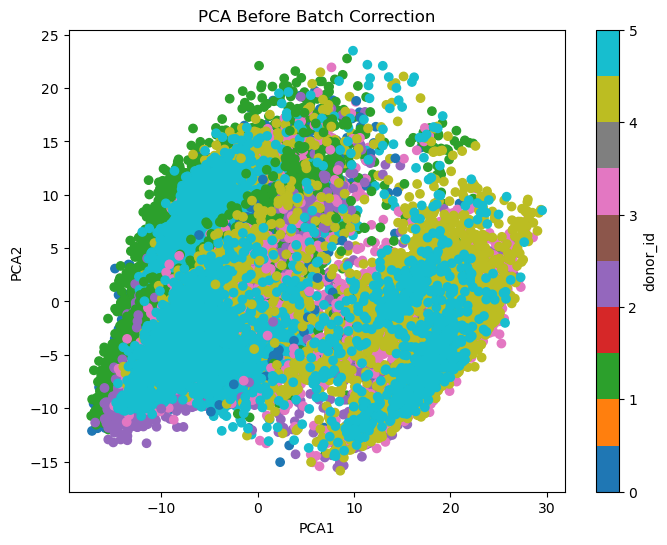

MemoryError: Unable to allocate 6.64 GiB for an array with shape (27203, 32745) and data type float64

In [25]:
# Step 1: Load required libraries
import scanpy as sc
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Importing the correct function from pycombat
from pycombat import Combat  # Import Combat class, not the module

# Load the data
adata = sc.read("C:/Users/marya/single-cell-project/Single-Cell-Transcriptomics/410b4cc9-1b18-4c1f-b109-12ed7a796060.h5ad")

# Step 2: Load and preprocess data
batch_key = "donor_id"  # Set the batch variable to 'donor_id'
condition_key = "Stage"  # Set the biological variable to 'Stage'

# Step 3: Visualize batch effects with PCA
def plot_pca(data, color_by, title):
    pca = PCA(n_components=2)
    components = pca.fit_transform(data.X)
    plt.figure(figsize=(8, 6))
    plt.scatter(components[:, 0], components[:, 1], c=data.obs[color_by].astype("category").cat.codes, cmap='tab10')
    plt.colorbar(label=color_by)
    plt.title(title)
    plt.xlabel("PCA1")
    plt.ylabel("PCA2")
    plt.show()

# Plot PCA before batch correction
plot_pca(adata, color_by=batch_key, title="PCA Before Batch Correction")

# Step 4: Batch Correction Methods

## A. ComBat using pyCombat
# Convert data to a suitable format for ComBat (if it is sparse, convert it to a dense array)
expression_data = pd.DataFrame(adata.X.toarray(), index=adata.obs_names, columns=adata.var_names)  # If sparse matrix

# Extract batch labels
batch_labels = adata.obs[batch_key].values  # Convert to a simple array if needed

# Ensure batch_labels is of the correct shape (1D numpy array)
batch_labels = np.asarray(batch_labels).flatten()

# Apply ComBat correction using pycombat
combat = Combat()
combat_corrected = combat.fit_transform(expression_data.values, batch_labels)  # Using .values ensures we pass a numpy array

# Update AnnData object with corrected data
adata.X = combat_corrected.T  # Transpose back to original format (cells x genes)

## B. Harmony (if applicable)
from harmony import harmonize
# Harmony requires integration with AnnData
adata_harmony = harmonize(adata.obsm['X_pca'], adata.obs, batch_key=batch_key)

# Update PCA embeddings in AnnData
adata.obsm["X_pca"] = adata_harmony

## C. BBKNN (for single-cell data)
import scanpy.external as sce

# Apply BBKNN for batch correction in neighbor graph
sce.pp.bbknn(adata, batch_key=batch_key)  # Updates the neighbor graph
sc.tl.umap(adata)  # Recompute UMAP embeddings

# Step 5: Validate Batch Correction
# Re-visualize PCA or UMAP
plot_pca(adata, color_by=batch_key, title="PCA After Batch Correction")

# Alternatively, use UMAP for single-cell data
sc.pl.umap(adata, color=batch_key, title="UMAP After Batch Correction")

# Step 6: Save corrected data
adata.write_h5ad("batch_corrected_dataset.h5ad")
